# 타이타닉 데이터 이진분류 정확도

In [1]:
import numpy as np
import pandas as pd
import tensorflow as tf
seed = 2022
np.random.seed(seed)
tf.random.set_seed(seed)

In [2]:
import seaborn as sns
titanic = sns.load_dataset('titanic')
titanic.head(3)

,survived,pclass,sex,age,sibsp,parch,fare,embarked,class,who,adult_male,deck,embark_town,alive,alone
0,0,3,male,22.0,1,0,7.2500,S,Third,man,True,NaN,Southampton,no,False
1,1,1,female,38.0,1,0,71.2833,C,First,woman,False,C,Cherbourg,yes,False
2,1,3,female,26.0,0,0,7.9250,S,Third,woman,False,NaN,Southampton,yes,True


- 데이터 전처리

In [3]:
titanic = titanic[['survived', 'pclass', 'sex', 'age', 'sibsp', 'parch', 'fare', 'embarked']]
titanic.head(3)

,survived,pclass,sex,age,sibsp,parch,fare,embarked
0,0,3,male,22.0,1,0,7.2500,S
1,1,1,female,38.0,1,0,71.2833,C
2,1,3,female,26.0,0,0,7.9250,S


In [4]:
# 결측치
titanic.isna().sum()

survived      0
pclass        0
sex           0
age         177
sibsp         0
parch         0
fare          0
embarked      2
dtype: int64

In [5]:
# age 결측치를 평균으로
titanic.age.fillna(titanic['age'].mean(), inplace=True)
titanic.age.isna().sum()

0

In [6]:
# embarked 결측치를 최빈값으로
titanic.embarked.value_counts()

S    644
C    168
Q     77
Name: embarked, dtype: int64

In [7]:
titanic.embarked.fillna('S', inplace=True)
titanic.embarked.isna().sum()

0

In [8]:
# sex, embarked 컬럼은 숫자로 변환 (LabelEncoder)
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()
titanic.sex = le.fit_transform(titanic.sex)
titanic.embarked = le.fit_transform(titanic.embarked)
titanic.head(3)

,survived,pclass,sex,age,sibsp,parch,fare,embarked
0,0,3,1,22.0,1,0,7.2500,2
1,1,1,0,38.0,1,0,71.2833,0
2,1,3,0,26.0,0,0,7.9250,2


In [9]:
# 생존율 예측 - X data Scaling
from sklearn.preprocessing import StandardScaler
X_scaled = StandardScaler().fit_transform(titanic.values[:,1:])

In [10]:
y = titanic.values[:,0]
X_scaled.shape, y.shape

((891, 7), (891,))

In [11]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(
    X_scaled, y, stratify=y, test_size=0.2, random_state=seed
)
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((712, 7), (179, 7), (712,), (179,))

- 모델 정의

In [12]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense

In [13]:
model = Sequential([
    Dense(200, input_dim=7, activation='relu'),
    Dense(150, activation='relu'),
    Dense(100, activation='relu'),
    Dense(60, activation='relu'),
    Dense(35, activation='relu'),
    Dense(12, activation='relu'),
    Dense(6, activation='relu'),
    Dense(1, activation='sigmoid')
])
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 200)               1600      
_________________________________________________________________
dense_1 (Dense)              (None, 150)               30150     
_________________________________________________________________
dense_2 (Dense)              (None, 100)               15100     
_________________________________________________________________
dense_3 (Dense)              (None, 60)                6060      
_________________________________________________________________
dense_4 (Dense)              (None, 35)                2135      
_________________________________________________________________
dense_5 (Dense)              (None, 12)                432       
_________________________________________________________________
dense_6 (Dense)              (None, 6)                 7

In [14]:
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

- 모델 저장관련 설정

In [15]:
import os
if not os.path.exists('model'):
    os.mkdir('model')

In [16]:
model_path = 'model/best_titanic.h5'

In [17]:
from tensorflow.keras.callbacks import ModelCheckpoint
checkpoint = ModelCheckpoint(
    model_path, monitor='val_loss', varbose=1, save_best_only=True
)

In [18]:
# 조기 종료
from tensorflow.keras.callbacks import EarlyStopping
early_stopping = EarlyStopping(patience=20)

- 모델 학습 및 저장

In [19]:
history = model.fit(X_train, y_train, validation_split=0.2, verbose=0,
            epochs=400, batch_size=200,
            callbacks=[checkpoint, early_stopping])

In [20]:
# 베스트 모델
from tensorflow.keras.models import load_model
best_model = load_model(model_path)
best_model.evaluate(X_test, y_test)

6/6 [==============================] - 0s 1ms/step - loss: 0.4066 - accuracy: 0.8547


[0.4065858721733093, 0.8547486066818237]

- 시각화

In [21]:
y_acc = history.history['accuracy']
y_vloss = history.history['val_loss']
xs = np.arange(1,len(y_acc)+1)

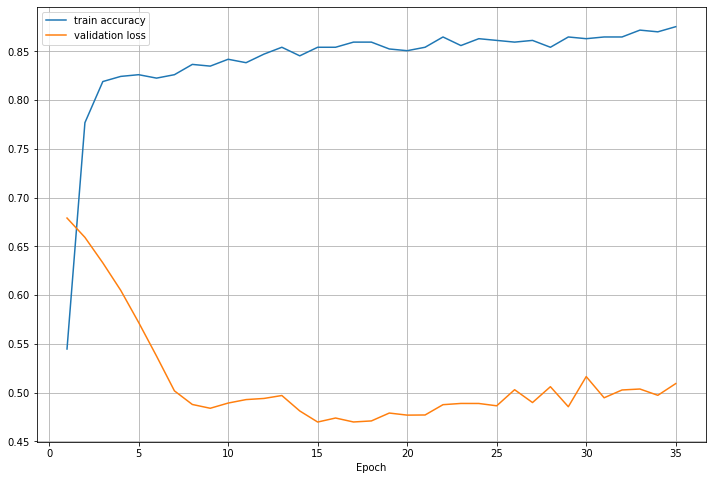

In [22]:
import matplotlib.pyplot as plt
plt.figure(figsize=(12,8))
plt.plot(xs, y_acc, ms=5, label='train accuracy')
plt.plot(xs, y_vloss, ms=5, label='validation loss')
plt.legend()
plt.grid()
plt.xlabel('Epoch')
plt.show()